### CLIP text + image search

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import torch
from torchvision import models, transforms
from PIL import Image
from transformers import CLIPModel
from transformers import CLIPProcessor
import time
import faiss

/Users/chiara/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/chiara/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/chiara/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: /Users/chiara/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/torchvision/image.so
  Expected in: /Users/chiara/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or 

In [2]:
def display_images_and_titles(filepaths, titles):
    # Create a 3x5 grid of subplots
    fig, axes = plt.subplots(3, 5, figsize=(12, 10))

    # Loop through the filepaths and display images in the subplots
    for i, ax in enumerate(axes.flatten()):
        if i < len(filepaths):
            filepath = filepaths[i]
            image = plt.imread(filepath)
            ax.imshow(image)
            ax.axis('off')

            # Assign a title to each subplot
            ax.set_title(f"{titles[i]}", fontsize = 7)
        else:
            ax.axis('off')

    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()

def display_images_titles_from_ids(ids, directory, df):
    df_new_index = df.copy()
    df_new_index['id'] = df_new_index['id'].astype(str)
    df_new_index.set_index("id",inplace = True)
    df_new_index = df_new_index.loc[ids]
    filenames = df_new_index.index.tolist()
    filepaths = [f"{os.path.join(directory,filename)}.jpg"  for filename in filenames]
    titles =  df_new_index.productDisplayName.tolist()
    
    display_images_and_titles(filepaths, titles)

    


In [3]:
def clip_search_image_and_text(path_to_image, text):
    
    #Import dataset
    filename = "./archive/myntradataset/styles.csv" # Modify directory
    df = pd.read_csv(filename, on_bad_lines="skip") #some lines of the dataset fail due to excess commas
    
    #Data Wrangling
    available_ids = os.listdir("./archive/myntradataset/images") # Modify directory
    available_ids = [int(x.replace(".jpg","")) for x in available_ids]
    df = df[df.id.isin(available_ids)] #some images are not actually available
    df=df.dropna(subset='productDisplayName')

    custom_image = Image.open(path_to_image)

    # Load model
    model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32") #Import CLIP Model
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

    #Extract text and image embeddings 
    image_vectors = torch.load("image_tensor.pt") # Modify directory
    image_vectors_np = image_vectors.numpy()

    text_vectors = torch.load("title_tensor.pt") # Modify directory
    text_vectors_np = text_vectors.numpy()
    
    knn_labels = df.id.astype(str).tolist()

    # Build the index
    dimension = image_vectors_np.shape[1]  # Dimension of the vectors
    index_image = faiss.IndexFlatL2(dimension)
    index_image.add(image_vectors_np)

    # Preprocess the custom image and text 
    inputs = processor(text=text, images=custom_image, return_tensors="pt", padding=True)

    # Perform inference on the custom image and text
    outputs = model(**inputs)

    #knn for text 
    np_text_emb = outputs.text_embeds.detach().cpu().numpy() #Get text query embedding
    k_text= 6000 # Number of text neighbors to return
    D_text, I_text = index_image.search(np_text_emb.reshape(1, -1) , k_text)
    
    #knn for image
    np_image_emb = outputs.image_embeds.detach().cpu().numpy() #Get image query embedding
    k_image= 450 # Number of image neighbors to return
    D_image, I_image = index_image.search(np_image_emb.reshape(1, -1), k_image)

    #Find insersection of knn image and text results and change order
    common_elements, indices_arr1, indices_arr2 = np.intersect1d(I_image[0], I_text[0], assume_unique=True, return_indices=True)
    common_elements_ordered = [I_text[0][i] for i in np.sort(indices_arr2)]

    # Retrieve the corresponding labels 
    common_ids_ordered = [knn_labels[i] for i in common_elements_ordered]

    return common_ids_ordered, df

### Running Code

In [4]:
local_pic = "Red_Bag.jpg" #Insert image directory
text=["brown"] #Insert text query
common_ids_ordered, df = clip_search_image_and_text(local_pic, text)


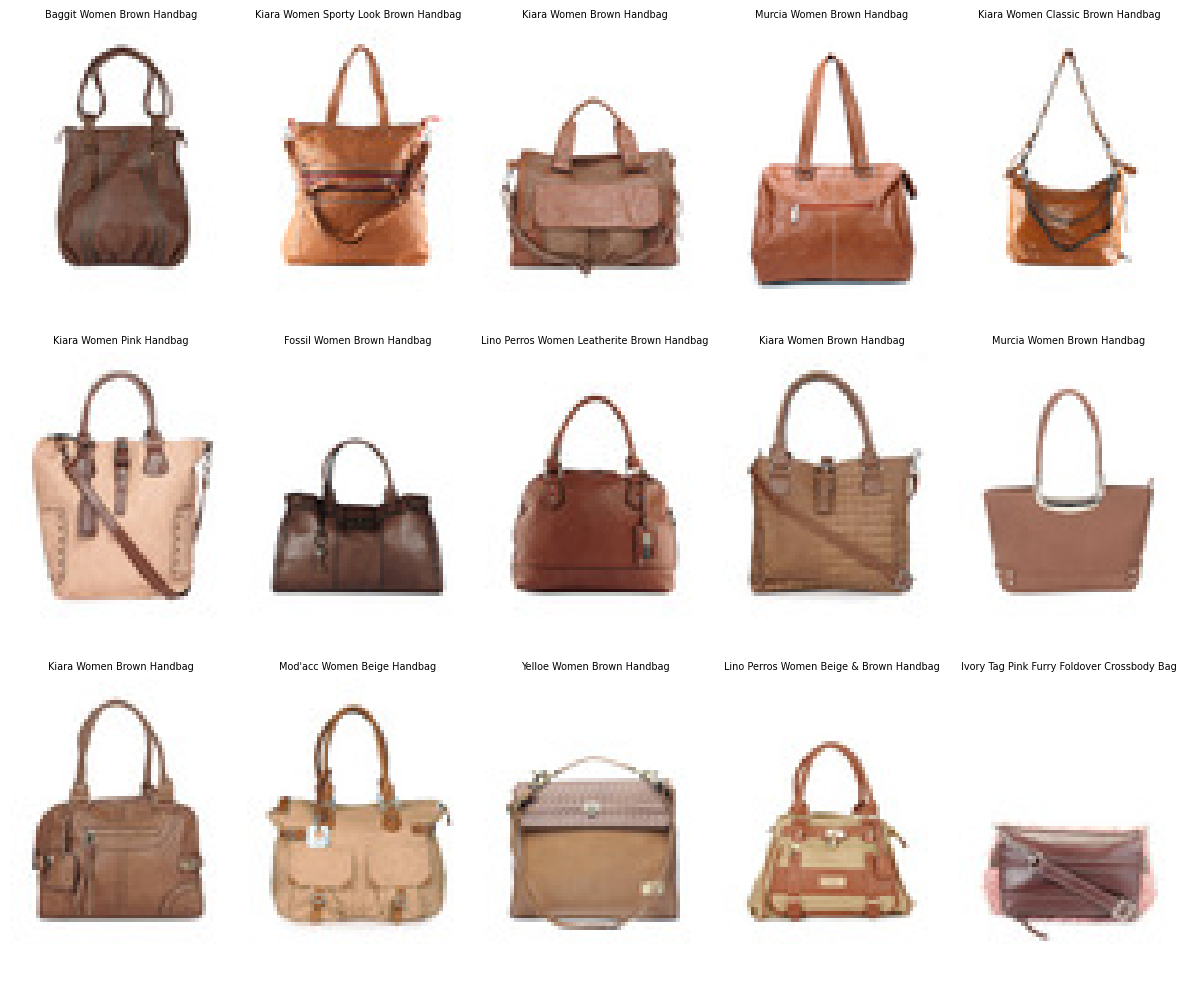

In [5]:
directory = "./archive/myntradataset/images/"  # Modify directory
display_images_titles_from_ids(common_ids_ordered, directory, df)

### Find product in the dataset

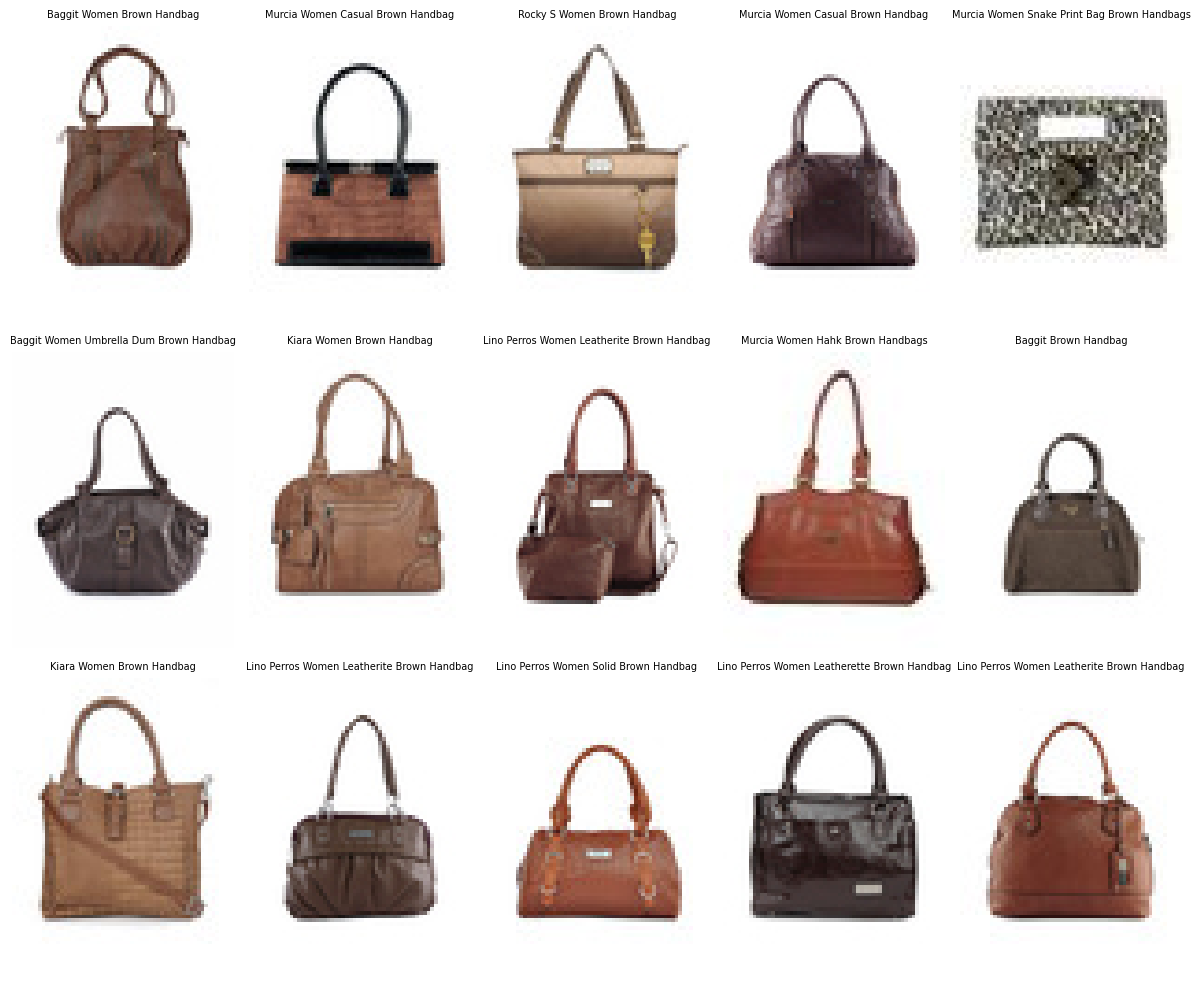

In [10]:
product = df.loc[(df['articleType'] == 'Handbags') & (df['baseColour'] == 'Brown')]
product_ids = product.id.astype(str).tolist()
display_images_titles_from_ids(product_ids, directory, df) 